# XGBRegression (LMA features to P,A coordinates)

## Imports

In [35]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.lines as mlines

import tensorflow as tf

import sklearn
from sklearn.model_selection import cross_val_score, KFold, StratifiedKFold

import xgboost as xgb

xgb.set_config(verbosity=2)

from sklearn.metrics import mean_squared_error, mean_absolute_error

from sklearn.utils import shuffle

## Load Data

In [2]:
#dataset = pd.read_csv('datasets/pa/Fs_B_N_LMA_DATA.csv')
#dataset = pd.read_csv('datasets/pa/Fs_N_LMA_DATA.csv')
#dataset = pd.read_csv('datasets/pa/Fs2_N_LMA_DATA_EXTRA.csv')
#dataset = pd.read_csv('datasets/pa/Fs_B2_N_LMA_DATA_EXTRA.csv')

#dataset = pd.read_csv('datasets/pa/Fs_N_LMA_DATA_EXTRA.csv')
dataset = pd.read_csv('datasets/pa/Fs_N_LMA_DATA_EXTRA_NEUTRAL.csv')

### Split into Test and Train data

In [3]:
train_dataset = dataset.sample(frac=0.8, random_state=42)
test_dataset = dataset.drop(train_dataset.index)

print("No Training Samples:",train_dataset.shape[0])
print("No Test Samples:",test_dataset.shape[0])

train_dataset = shuffle(train_dataset)
test_dataset = shuffle(test_dataset)

No Training Samples: 45087
No Test Samples: 11272


### Split Features from Targets

In [4]:
train_X = train_dataset.copy()
test_X = test_dataset.copy()

train_y = pd.concat([train_X.pop(x) for x in ['EMOTION_P', 'EMOTION_A']], axis=1)
test_y = pd.concat([test_X.pop(x) for x in ['EMOTION_P', 'EMOTION_A']], axis=1)

test_y_p = test_y.iloc[:,0]
train_y_p = train_y.iloc[:,0]

test_y_a = test_y.iloc[:,1]
train_y_a = train_y.iloc[:,1]

In [5]:
train_X.head()

avg_hand_distance  avg_l_hand_hip_distance  avg_r_hand_hip_distance  \
23645           0.386145                 0.289682                 0.272905   
22773           0.756434                 0.385899                 0.762562   
40871           0.431519                 0.636741                 0.588062   
38398           0.190285                 0.191954                 0.245657   
4346            0.583562                 0.240309                 0.629033   

       avg_feet_distance  avg_l_hand_chest_distance  \
23645           0.122893                   0.643832   
22773           0.253628                   0.694133   
40871           0.298824                   0.750960   
38398           0.215687                   0.564221   
4346            0.274378                   0.594281   

       avg_r_hand_chest_distance  avg_l_elbow_hip_distance  \
23645                   0.627023                  0.573009   
22773                   0.778141                  0.641876   
40871                   0.723189                  0.693800   
38398                   0.528740                  0.466707   
4346                    0.743033                  0.513947   

       avg_r_elbow_hip_distance  avg_chest_pelvis_distance  \
23645                  0.561757                   0.263210   
22773                  0.816914                   0.255892   
40871                  0.662809                   0.262511   
38398                  0.421020                   0.341410   
4346                   0.694758                   0.270146   

       avg_neck_chest_distance  ...  avg_pelvis_velocity_y  \
23645                 0.998517  ...               0.478936   
22773                 0.984629  ...               0.507456   
40871                 0.998165  ...               0.469143   
38398                 0.950505  ...               0.466753   
4346                  0.994500  ...               0.504846   

       avg_pelvis_velocity_z  avg_l_foot_velocity_x  avg_l_foot_velocity_y  \
23645               0.481982               0.590816               0.619317   
22773               0.447254               0.597458               0.623525   
40871               0.545884               0.592450               0.611776   
38398               0.474123               0.592332               0.593241   
4346                0.489602               0.587728               0.614034   

       avg_l_foot_velocity_z  avg_r_foot_velocity_x  avg_r_foot_velocity_y  \
23645               0.336081               0.448871               0.497298   
22773               0.338189               0.455445               0.499938   
40871               0.335615               0.450489               0.492565   
38398               0.277612               0.436026               0.537028   
4346                0.343253               0.445814               0.493982   

       avg_r_foot_velocity_z  avg_upper_body_volume  avg_distance_traveled  
23645               0.538551               0.409763               0.001928  
22773               0.540911               0.693156               0.088915  
40871               0.538029               0.389446               0.055672  
38398               0.493381               0.209899               0.022981  
4346                0.546583               0.453651               0.034770  

[5 rows x 33 columns]

In [6]:
train_y.head()

EMOTION_P  EMOTION_A
23645      -0.35       0.70
22773      -0.50       0.60
40871      -0.35       0.70
38398      -0.60      -0.30
4346       -0.40       0.25

In [7]:
train_X.describe().transpose()[['mean', 'std']]

mean       std
avg_hand_distance          0.367866  0.202526
avg_l_hand_hip_distance    0.354570  0.185754
avg_r_hand_hip_distance    0.369125  0.193929
avg_feet_distance          0.221029  0.105025
avg_l_hand_chest_distance  0.566260  0.164762
avg_r_hand_chest_distance  0.563325  0.164601
avg_l_elbow_hip_distance   0.525713  0.154588
avg_r_elbow_hip_distance   0.526010  0.155729
avg_chest_pelvis_distance  0.268310  0.023227
avg_neck_chest_distance    0.982620  0.035712
avg_neck_rotation_w        0.476252  0.071978
avg_neck_rotation_x        0.438399  0.173934
avg_neck_rotation_y        0.443365  0.086577
avg_neck_rotation_z        0.921091  0.167569
avg_pelvis_rotation_w      0.518902  0.059338
avg_pelvis_rotation_x      0.437719  0.177642
avg_pelvis_rotation_y      0.421655  0.074516
avg_pelvis_rotation_z      0.925631  0.163795
std_l_hand_position        0.123915  0.127292
std_r_hand_position        0.126052  0.128747
avg_l_forearm_velocity     0.523746  0.065931
avg_r_forearm_velocity     0.466473  0.061265
avg_pelvis_velocity_x      0.595003  0.038377
avg_pelvis_velocity_y      0.476610  0.027967
avg_pelvis_velocity_z      0.481474  0.044548
avg_l_foot_velocity_x      0.590995  0.018215
avg_l_foot_velocity_y      0.619563  0.027526
avg_l_foot_velocity_z      0.335727  0.022738
avg_r_foot_velocity_x      0.448884  0.016939
avg_r_foot_velocity_y      0.497207  0.017822
avg_r_foot_velocity_z      0.538277  0.026444
avg_upper_body_volume      0.424719  0.175602
avg_distance_traveled      0.040045  0.045548

## Define Model

In [10]:
xgbr = xgb.XGBRegressor(verbosity=1) 


# Current Best:
# n_estimators = 2000
# learning_rate = 0.05
# max_depth = 10
# min_child_weight = 11
# subsample = 1
# gamma = 0

# Try something like:
# {'objective': 'reg:linear', 'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bynode': 1, 'colsample_bytree': 1.0, 'enable_categorical': False, 'gamma': 0.5, 'gpu_id': -1, 'importance_type': None, 'interaction_constraints': '', 'learning_rate': 0.05, 'max_delta_step': 0, 'max_depth': 20, 'min_child_weight': 22, 'missing': nan, 'monotone_constraints': '()', 'n_estimators': 1000, 'n_jobs': 8, 'num_parallel_tree': 1, 'predictor': 'auto', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 1, 'scale_pos_weight': 1, 'subsample': 0.5, 'tree_method': 'exact', 'validate_parameters': 1, 'verbosity': None}

# Best:
#
#
#{'objective': 'reg:squarederror', 'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bynode': 1, 'colsample_bytree': 1, 'enable_categorical': False, 'gamma': 0, 'gpu_id': 0, 'importance_type': None, 'interaction_constraints': '', 'learning_rate': 0.05, 'max_delta_step': 0, 'max_depth': 10, 'min_child_weight': 5, 'missing': nan, 'monotone_constraints': '()', 'n_estimators': 1000, 'n_jobs': 12, 'num_parallel_tree': 1, 'predictor': 'auto', 'random_state': 0, 'reg_alpha': 0.5, 'reg_lambda': 1.5, 'scale_pos_weight': 1, 'subsample': 0.8, 'tree_method': 'gpu_hist', 'validate_parameters': 1, 'verbosity': None, 'lambda': 1.5, 'alpha': 0.5}
#

model_p = xgb.XGBRegressor(
                    n_estimators=1000, learning_rate=0.08, max_depth=15, min_child_weight=5, 
                    reg_alpha=0.5, reg_lambda=1.5,
                    subsample=0.8, colsample_bytree=1, objective="reg:squarederror"
                )

model_a = xgb.XGBRegressor(
                    n_estimators=1000, learning_rate=0.08, max_depth=15, min_child_weight=5, 
                    reg_alpha=0.5, reg_lambda=1.5,
                    subsample=0.8, colsample_bytree=1, objective="reg:squarederror"
                )

## Train Model

### Pleasure Regression

In [11]:
model_p.fit(train_X, train_y_p)

/home/ds/.local/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[19:41:45] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 2574 extra nodes, 0 pruned nodes, max_depth=15
[19:41:46] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 2402 extra nodes, 0 pruned nodes, max_depth=15
[19:41:46] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 2500 extra nodes, 0 pruned nodes, max_depth=15
[19:41:46] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 2568 extra nodes, 0 pruned nodes, max_depth=15
[19:41:46] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 2340 extra nodes, 0 pruned nodes, max_depth=15
[19:41:46] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 2316 extra nodes, 0 pruned nodes, max_depth=15
[19:41:46] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 2588 extra nodes, 0 pruned nodes, max_depth=15
[19:41:47] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 2424 extra nodes, 0 pruned nodes, max_depth=15
[19:41:47] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 259

[19:41:59] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 3052 extra nodes, 0 pruned nodes, max_depth=15
[19:41:59] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 3312 extra nodes, 0 pruned nodes, max_depth=15
[19:41:59] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 2744 extra nodes, 0 pruned nodes, max_depth=15
[19:41:59] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 1956 extra nodes, 0 pruned nodes, max_depth=15
[19:41:59] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 1782 extra nodes, 0 pruned nodes, max_depth=15
[19:42:00] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 3374 extra nodes, 0 pruned nodes, max_depth=15
[19:42:00] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 2328 extra nodes, 0 pruned nodes, max_depth=15
[19:42:00] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 1850 extra nodes, 0 pruned nodes, max_depth=15
[19:42:00] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 439

[19:42:13] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 2654 extra nodes, 0 pruned nodes, max_depth=15
[19:42:13] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 3712 extra nodes, 0 pruned nodes, max_depth=15
[19:42:13] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 1850 extra nodes, 0 pruned nodes, max_depth=15
[19:42:13] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 3846 extra nodes, 0 pruned nodes, max_depth=15
[19:42:14] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 1818 extra nodes, 0 pruned nodes, max_depth=15
[19:42:14] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 3732 extra nodes, 0 pruned nodes, max_depth=15
[19:42:14] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 2810 extra nodes, 0 pruned nodes, max_depth=15
[19:42:14] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 2682 extra nodes, 0 pruned nodes, max_depth=15
[19:42:14] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 255

[19:42:27] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 2378 extra nodes, 0 pruned nodes, max_depth=15
[19:42:27] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 2430 extra nodes, 0 pruned nodes, max_depth=15
[19:42:27] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 2050 extra nodes, 0 pruned nodes, max_depth=15
[19:42:27] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 1960 extra nodes, 0 pruned nodes, max_depth=15
[19:42:27] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 1654 extra nodes, 0 pruned nodes, max_depth=15
[19:42:28] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 1736 extra nodes, 0 pruned nodes, max_depth=15
[19:42:28] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 2548 extra nodes, 0 pruned nodes, max_depth=15
[19:42:28] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 1962 extra nodes, 0 pruned nodes, max_depth=15
[19:42:28] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 220

[19:42:40] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 1322 extra nodes, 0 pruned nodes, max_depth=15
[19:42:40] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 1700 extra nodes, 0 pruned nodes, max_depth=15
[19:42:40] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 1584 extra nodes, 0 pruned nodes, max_depth=15
[19:42:40] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 1580 extra nodes, 0 pruned nodes, max_depth=15
[19:42:41] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 1766 extra nodes, 0 pruned nodes, max_depth=15
[19:42:41] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 1718 extra nodes, 0 pruned nodes, max_depth=15
[19:42:41] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 1708 extra nodes, 0 pruned nodes, max_depth=15
[19:42:41] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 1784 extra nodes, 0 pruned nodes, max_depth=15
[19:42:41] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 129

[19:42:53] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 1204 extra nodes, 0 pruned nodes, max_depth=15
[19:42:53] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 1294 extra nodes, 0 pruned nodes, max_depth=15
[19:42:53] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 1488 extra nodes, 0 pruned nodes, max_depth=15
[19:42:53] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 1268 extra nodes, 0 pruned nodes, max_depth=15
[19:42:53] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 1330 extra nodes, 0 pruned nodes, max_depth=15
[19:42:53] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 1270 extra nodes, 0 pruned nodes, max_depth=15
[19:42:54] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 1402 extra nodes, 0 pruned nodes, max_depth=15
[19:42:54] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 1126 extra nodes, 0 pruned nodes, max_depth=15
[19:42:54] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 130

[19:43:05] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 988 extra nodes, 0 pruned nodes, max_depth=15
[19:43:05] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 1102 extra nodes, 0 pruned nodes, max_depth=15
[19:43:05] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 932 extra nodes, 0 pruned nodes, max_depth=15
[19:43:05] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 970 extra nodes, 0 pruned nodes, max_depth=15
[19:43:05] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 984 extra nodes, 0 pruned nodes, max_depth=15
[19:43:06] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 914 extra nodes, 0 pruned nodes, max_depth=15
[19:43:06] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 960 extra nodes, 0 pruned nodes, max_depth=15
[19:43:06] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 908 extra nodes, 0 pruned nodes, max_depth=15
[19:43:06] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 790 extra 

[19:43:17] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 672 extra nodes, 0 pruned nodes, max_depth=15
[19:43:17] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 782 extra nodes, 0 pruned nodes, max_depth=15
[19:43:17] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 628 extra nodes, 0 pruned nodes, max_depth=15
[19:43:17] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 718 extra nodes, 0 pruned nodes, max_depth=15
[19:43:17] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 792 extra nodes, 0 pruned nodes, max_depth=15
[19:43:17] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 800 extra nodes, 0 pruned nodes, max_depth=15
[19:43:17] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 674 extra nodes, 0 pruned nodes, max_depth=15
[19:43:18] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 912 extra nodes, 0 pruned nodes, max_depth=15
[19:43:18] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 886 extra n

[19:43:28] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 630 extra nodes, 0 pruned nodes, max_depth=15
[19:43:28] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 544 extra nodes, 0 pruned nodes, max_depth=15
[19:43:28] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 566 extra nodes, 0 pruned nodes, max_depth=15
[19:43:29] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 658 extra nodes, 0 pruned nodes, max_depth=15
[19:43:29] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 592 extra nodes, 0 pruned nodes, max_depth=15
[19:43:29] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 706 extra nodes, 0 pruned nodes, max_depth=15
[19:43:29] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 580 extra nodes, 0 pruned nodes, max_depth=15
[19:43:29] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 666 extra nodes, 0 pruned nodes, max_depth=15
[19:43:29] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 754 extra n

[19:43:40] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 524 extra nodes, 0 pruned nodes, max_depth=15
[19:43:40] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 474 extra nodes, 0 pruned nodes, max_depth=15
[19:43:40] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 568 extra nodes, 0 pruned nodes, max_depth=15
[19:43:40] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 558 extra nodes, 0 pruned nodes, max_depth=15
[19:43:40] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 548 extra nodes, 0 pruned nodes, max_depth=15
[19:43:40] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 544 extra nodes, 0 pruned nodes, max_depth=15
[19:43:41] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 550 extra nodes, 0 pruned nodes, max_depth=15
[19:43:41] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 528 extra nodes, 0 pruned nodes, max_depth=15
[19:43:41] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 450 extra n

[19:43:51] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 496 extra nodes, 0 pruned nodes, max_depth=15
[19:43:51] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 588 extra nodes, 0 pruned nodes, max_depth=15
[19:43:51] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 440 extra nodes, 0 pruned nodes, max_depth=15
[19:43:51] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 386 extra nodes, 0 pruned nodes, max_depth=15
[19:43:52] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 466 extra nodes, 0 pruned nodes, max_depth=15
[19:43:52] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 464 extra nodes, 0 pruned nodes, max_depth=15
[19:43:52] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 564 extra nodes, 0 pruned nodes, max_depth=15
[19:43:52] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 414 extra nodes, 0 pruned nodes, max_depth=15
[19:43:52] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 466 extra n

[19:44:02] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 372 extra nodes, 0 pruned nodes, max_depth=15
[19:44:02] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 424 extra nodes, 0 pruned nodes, max_depth=15
[19:44:02] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 384 extra nodes, 0 pruned nodes, max_depth=15
[19:44:02] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 366 extra nodes, 0 pruned nodes, max_depth=15
[19:44:02] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 474 extra nodes, 0 pruned nodes, max_depth=15
[19:44:02] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 444 extra nodes, 0 pruned nodes, max_depth=15
[19:44:03] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 370 extra nodes, 0 pruned nodes, max_depth=15
[19:44:03] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 364 extra nodes, 0 pruned nodes, max_depth=15
[19:44:03] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 372 extra n

[19:44:12] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 316 extra nodes, 0 pruned nodes, max_depth=15
[19:44:12] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 356 extra nodes, 0 pruned nodes, max_depth=15
[19:44:12] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 354 extra nodes, 0 pruned nodes, max_depth=15
[19:44:13] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 454 extra nodes, 0 pruned nodes, max_depth=15
[19:44:13] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 340 extra nodes, 0 pruned nodes, max_depth=15
[19:44:13] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 308 extra nodes, 0 pruned nodes, max_depth=15
[19:44:13] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 374 extra nodes, 0 pruned nodes, max_depth=15
[19:44:13] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 410 extra nodes, 0 pruned nodes, max_depth=15
[19:44:13] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 294 extra n

[19:44:23] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 252 extra nodes, 0 pruned nodes, max_depth=15
[19:44:23] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 334 extra nodes, 0 pruned nodes, max_depth=15
[19:44:23] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 286 extra nodes, 0 pruned nodes, max_depth=15
[19:44:23] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 396 extra nodes, 0 pruned nodes, max_depth=15
[19:44:23] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 290 extra nodes, 0 pruned nodes, max_depth=15
[19:44:23] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 354 extra nodes, 0 pruned nodes, max_depth=15
[19:44:23] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 382 extra nodes, 0 pruned nodes, max_depth=15
[19:44:24] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 342 extra nodes, 0 pruned nodes, max_depth=15
[19:44:24] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 294 extra n

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.08, max_delta_step=0,
             max_depth=15, min_child_weight=5, missing=nan,
             monotone_constraints='()', n_estimators=1000, n_jobs=8,
             num_parallel_tree=1, predictor='auto', random_state=0,
             reg_alpha=0.5, reg_lambda=1.5, scale_pos_weight=1, subsample=0.8,
             tree_method='exact', validate_parameters=1, verbosity=None)

### Arousal Regression

In [12]:
model_a.fit(train_X, train_y_a)

[19:44:35] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 3140 extra nodes, 0 pruned nodes, max_depth=15
[19:44:35] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 3128 extra nodes, 0 pruned nodes, max_depth=15
[19:44:35] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 3126 extra nodes, 0 pruned nodes, max_depth=15
[19:44:35] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 3408 extra nodes, 0 pruned nodes, max_depth=15
[19:44:35] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 3290 extra nodes, 0 pruned nodes, max_depth=15
[19:44:36] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 3214 extra nodes, 0 pruned nodes, max_depth=15
[19:44:36] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 3044 extra nodes, 0 pruned nodes, max_depth=15
[19:44:36] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 2852 extra nodes, 0 pruned nodes, max_depth=15
[19:44:36] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 351

[19:44:48] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 3208 extra nodes, 0 pruned nodes, max_depth=15
[19:44:48] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 3930 extra nodes, 0 pruned nodes, max_depth=15
[19:44:48] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 1514 extra nodes, 0 pruned nodes, max_depth=15
[19:44:49] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 3374 extra nodes, 0 pruned nodes, max_depth=15
[19:44:49] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 2632 extra nodes, 0 pruned nodes, max_depth=15
[19:44:49] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 2548 extra nodes, 0 pruned nodes, max_depth=15
[19:44:49] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 2294 extra nodes, 0 pruned nodes, max_depth=15
[19:44:49] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 2184 extra nodes, 0 pruned nodes, max_depth=15
[19:44:49] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 958

[19:45:02] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 2928 extra nodes, 0 pruned nodes, max_depth=15
[19:45:02] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 1954 extra nodes, 0 pruned nodes, max_depth=15
[19:45:03] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 3196 extra nodes, 0 pruned nodes, max_depth=15
[19:45:03] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 3096 extra nodes, 0 pruned nodes, max_depth=15
[19:45:03] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 2380 extra nodes, 0 pruned nodes, max_depth=15
[19:45:03] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 1946 extra nodes, 0 pruned nodes, max_depth=15
[19:45:03] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 2062 extra nodes, 0 pruned nodes, max_depth=15
[19:45:04] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 2764 extra nodes, 0 pruned nodes, max_depth=15
[19:45:04] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 226

[19:45:17] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 1258 extra nodes, 0 pruned nodes, max_depth=15
[19:45:17] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 1256 extra nodes, 0 pruned nodes, max_depth=15
[19:45:17] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 2096 extra nodes, 0 pruned nodes, max_depth=15
[19:45:18] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 1860 extra nodes, 0 pruned nodes, max_depth=15
[19:45:18] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 2168 extra nodes, 0 pruned nodes, max_depth=15
[19:45:18] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 1724 extra nodes, 0 pruned nodes, max_depth=15
[19:45:18] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 2540 extra nodes, 0 pruned nodes, max_depth=15
[19:45:19] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 2516 extra nodes, 0 pruned nodes, max_depth=15
[19:45:19] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 154

[19:45:31] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 872 extra nodes, 0 pruned nodes, max_depth=15
[19:45:31] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 1418 extra nodes, 0 pruned nodes, max_depth=15
[19:45:31] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 1308 extra nodes, 0 pruned nodes, max_depth=15
[19:45:32] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 744 extra nodes, 0 pruned nodes, max_depth=15
[19:45:32] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 1580 extra nodes, 0 pruned nodes, max_depth=15
[19:45:32] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 1028 extra nodes, 0 pruned nodes, max_depth=15
[19:45:32] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 1244 extra nodes, 0 pruned nodes, max_depth=15
[19:45:32] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 1442 extra nodes, 0 pruned nodes, max_depth=15
[19:45:33] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 1308 

[19:45:45] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 1016 extra nodes, 0 pruned nodes, max_depth=15
[19:45:45] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 1104 extra nodes, 0 pruned nodes, max_depth=15
[19:45:45] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 1156 extra nodes, 0 pruned nodes, max_depth=15
[19:45:45] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 1244 extra nodes, 0 pruned nodes, max_depth=15
[19:45:46] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 1284 extra nodes, 0 pruned nodes, max_depth=15
[19:45:46] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 1032 extra nodes, 0 pruned nodes, max_depth=15
[19:45:46] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 1128 extra nodes, 0 pruned nodes, max_depth=15
[19:45:46] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 1168 extra nodes, 0 pruned nodes, max_depth=15
[19:45:46] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 954

[19:45:58] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 848 extra nodes, 0 pruned nodes, max_depth=15
[19:45:58] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 780 extra nodes, 0 pruned nodes, max_depth=15
[19:45:58] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 966 extra nodes, 0 pruned nodes, max_depth=15
[19:45:58] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 900 extra nodes, 0 pruned nodes, max_depth=15
[19:45:58] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 684 extra nodes, 0 pruned nodes, max_depth=15
[19:45:59] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 800 extra nodes, 0 pruned nodes, max_depth=15
[19:45:59] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 830 extra nodes, 0 pruned nodes, max_depth=15
[19:45:59] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 706 extra nodes, 0 pruned nodes, max_depth=15
[19:45:59] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 708 extra n

[19:46:10] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 632 extra nodes, 0 pruned nodes, max_depth=15
[19:46:10] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 736 extra nodes, 0 pruned nodes, max_depth=15
[19:46:10] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 784 extra nodes, 0 pruned nodes, max_depth=15
[19:46:10] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 608 extra nodes, 0 pruned nodes, max_depth=15
[19:46:11] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 652 extra nodes, 0 pruned nodes, max_depth=15
[19:46:11] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 718 extra nodes, 0 pruned nodes, max_depth=15
[19:46:11] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 600 extra nodes, 0 pruned nodes, max_depth=15
[19:46:11] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 654 extra nodes, 0 pruned nodes, max_depth=15
[19:46:11] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 664 extra n

[19:46:22] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 534 extra nodes, 0 pruned nodes, max_depth=15
[19:46:22] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 524 extra nodes, 0 pruned nodes, max_depth=15
[19:46:22] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 506 extra nodes, 0 pruned nodes, max_depth=15
[19:46:22] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 622 extra nodes, 0 pruned nodes, max_depth=15
[19:46:22] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 466 extra nodes, 0 pruned nodes, max_depth=15
[19:46:23] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 556 extra nodes, 0 pruned nodes, max_depth=15
[19:46:23] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 588 extra nodes, 0 pruned nodes, max_depth=15
[19:46:23] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 598 extra nodes, 0 pruned nodes, max_depth=15
[19:46:23] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 556 extra n

[19:46:33] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 326 extra nodes, 0 pruned nodes, max_depth=15
[19:46:34] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 534 extra nodes, 0 pruned nodes, max_depth=15
[19:46:34] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 310 extra nodes, 0 pruned nodes, max_depth=15
[19:46:34] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 496 extra nodes, 0 pruned nodes, max_depth=15
[19:46:34] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 402 extra nodes, 0 pruned nodes, max_depth=15
[19:46:34] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 466 extra nodes, 0 pruned nodes, max_depth=15
[19:46:34] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 392 extra nodes, 0 pruned nodes, max_depth=15
[19:46:35] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 410 extra nodes, 0 pruned nodes, max_depth=15
[19:46:35] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 532 extra n

[19:46:45] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 378 extra nodes, 0 pruned nodes, max_depth=15
[19:46:45] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 428 extra nodes, 0 pruned nodes, max_depth=15
[19:46:45] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 396 extra nodes, 0 pruned nodes, max_depth=15
[19:46:45] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 364 extra nodes, 0 pruned nodes, max_depth=15
[19:46:45] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 516 extra nodes, 0 pruned nodes, max_depth=15
[19:46:46] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 484 extra nodes, 0 pruned nodes, max_depth=15
[19:46:46] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 270 extra nodes, 0 pruned nodes, max_depth=15
[19:46:46] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 450 extra nodes, 0 pruned nodes, max_depth=15
[19:46:46] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 448 extra n

[19:46:56] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 314 extra nodes, 0 pruned nodes, max_depth=15
[19:46:56] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 346 extra nodes, 0 pruned nodes, max_depth=15
[19:46:56] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 286 extra nodes, 0 pruned nodes, max_depth=15
[19:46:56] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 394 extra nodes, 0 pruned nodes, max_depth=15
[19:46:56] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 366 extra nodes, 0 pruned nodes, max_depth=15
[19:46:57] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 380 extra nodes, 0 pruned nodes, max_depth=15
[19:46:57] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 432 extra nodes, 0 pruned nodes, max_depth=15
[19:46:57] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 312 extra nodes, 0 pruned nodes, max_depth=15
[19:46:57] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 408 extra n

[19:47:07] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 292 extra nodes, 0 pruned nodes, max_depth=15
[19:47:07] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 234 extra nodes, 0 pruned nodes, max_depth=15
[19:47:07] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 332 extra nodes, 0 pruned nodes, max_depth=15
[19:47:07] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 368 extra nodes, 0 pruned nodes, max_depth=15
[19:47:07] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 312 extra nodes, 0 pruned nodes, max_depth=15
[19:47:08] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 362 extra nodes, 0 pruned nodes, max_depth=15
[19:47:08] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 280 extra nodes, 0 pruned nodes, max_depth=15
[19:47:08] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 358 extra nodes, 0 pruned nodes, max_depth=15
[19:47:08] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 372 extra n

[19:47:18] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 262 extra nodes, 0 pruned nodes, max_depth=15
[19:47:18] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 332 extra nodes, 0 pruned nodes, max_depth=15
[19:47:18] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 284 extra nodes, 0 pruned nodes, max_depth=15
[19:47:18] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 300 extra nodes, 0 pruned nodes, max_depth=15
[19:47:18] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 304 extra nodes, 0 pruned nodes, max_depth=15
[19:47:18] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 266 extra nodes, 0 pruned nodes, max_depth=15
[19:47:19] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 320 extra nodes, 0 pruned nodes, max_depth=15
[19:47:19] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 252 extra nodes, 0 pruned nodes, max_depth=15
[19:47:19] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 196 extra n

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.08, max_delta_step=0,
             max_depth=15, min_child_weight=5, missing=nan,
             monotone_constraints='()', n_estimators=1000, n_jobs=8,
             num_parallel_tree=1, predictor='auto', random_state=0,
             reg_alpha=0.5, reg_lambda=1.5, scale_pos_weight=1, subsample=0.8,
             tree_method='exact', validate_parameters=1, verbosity=None)

## Test Model

### Training Score

In [13]:
score = model_p.score(train_X, train_y_p)  

print("Pleasure")
print("Training score: ", score)

print()

score = model_a.score(train_X, train_y_a)  

print("Arousal")
print("Training score: ", score)

Pleasure
Training score:  0.999727023219456



/home/ds/.local/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


Arousal
Training score:  0.9986722516110799


### 10-Fold Cross Validation Average Score

In [ ]:
kfold = KFold(n_splits=10, shuffle=True)

scores_p = cross_val_score(model_p, train_X, train_y_p,cv=kfold)

scores_a = cross_val_score(model_a, train_X, train_y_a,cv=kfold)

print("\n\nPleasure")
print("Training score: ", scores_p)
print("Mean cross-validation score: %.2f" % scores_p.mean())


print("\nArousal")
print("Training score: ", scores_a)
print("Mean cross-validation score: %.2f" % scores_a.mean())

/home/ds/.local/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[19:47:31] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 2148 extra nodes, 0 pruned nodes, max_depth=15
[19:47:31] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 2138 extra nodes, 0 pruned nodes, max_depth=15
[19:47:32] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 2254 extra nodes, 0 pruned nodes, max_depth=15
[19:47:32] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 2258 extra nodes, 0 pruned nodes, max_depth=15
[19:47:32] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 2224 extra nodes, 0 pruned nodes, max_depth=15
[19:47:32] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 2160 extra nodes, 0 pruned nodes, max_depth=15
[19:47:32] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 2222 extra nodes, 0 pruned nodes, max_depth=15
[19:47:32] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 2214 extra nodes, 0 pruned nodes, max_depth=15
[19:47:33] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 218

[19:47:43] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 2232 extra nodes, 0 pruned nodes, max_depth=15
[19:47:43] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 2256 extra nodes, 0 pruned nodes, max_depth=15
[19:47:44] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 1758 extra nodes, 0 pruned nodes, max_depth=15
[19:47:44] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 2610 extra nodes, 0 pruned nodes, max_depth=15
[19:47:44] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 2228 extra nodes, 0 pruned nodes, max_depth=15
[19:47:44] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 2668 extra nodes, 0 pruned nodes, max_depth=15
[19:47:44] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 3388 extra nodes, 0 pruned nodes, max_depth=15
[19:47:44] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 1774 extra nodes, 0 pruned nodes, max_depth=15
[19:47:45] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 240

[19:47:56] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 3218 extra nodes, 0 pruned nodes, max_depth=15
[19:47:56] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 2276 extra nodes, 0 pruned nodes, max_depth=15
[19:47:56] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 3236 extra nodes, 0 pruned nodes, max_depth=15
[19:47:57] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 2692 extra nodes, 0 pruned nodes, max_depth=15
[19:47:57] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 2368 extra nodes, 0 pruned nodes, max_depth=15
[19:47:57] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 3492 extra nodes, 0 pruned nodes, max_depth=15
[19:47:57] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 2284 extra nodes, 0 pruned nodes, max_depth=15
[19:47:57] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 2568 extra nodes, 0 pruned nodes, max_depth=15
[19:47:58] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 252

[19:48:09] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 2528 extra nodes, 0 pruned nodes, max_depth=15
[19:48:09] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 1818 extra nodes, 0 pruned nodes, max_depth=15
[19:48:09] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 2720 extra nodes, 0 pruned nodes, max_depth=15
[19:48:09] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 2034 extra nodes, 0 pruned nodes, max_depth=15
[19:48:10] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 2506 extra nodes, 0 pruned nodes, max_depth=15
[19:48:10] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 1980 extra nodes, 0 pruned nodes, max_depth=15
[19:48:10] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 1972 extra nodes, 0 pruned nodes, max_depth=15
[19:48:10] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 2020 extra nodes, 0 pruned nodes, max_depth=15
[19:48:10] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 230

[19:48:21] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 1710 extra nodes, 0 pruned nodes, max_depth=15
[19:48:21] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 1716 extra nodes, 0 pruned nodes, max_depth=15
[19:48:22] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 1444 extra nodes, 0 pruned nodes, max_depth=15
[19:48:22] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 1358 extra nodes, 0 pruned nodes, max_depth=15
[19:48:22] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 1314 extra nodes, 0 pruned nodes, max_depth=15
[19:48:22] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 1312 extra nodes, 0 pruned nodes, max_depth=15
[19:48:22] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 1660 extra nodes, 0 pruned nodes, max_depth=15
[19:48:22] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 1676 extra nodes, 0 pruned nodes, max_depth=15
[19:48:23] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 130

[19:48:33] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 936 extra nodes, 0 pruned nodes, max_depth=15
[19:48:33] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 1032 extra nodes, 0 pruned nodes, max_depth=15
[19:48:33] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 1102 extra nodes, 0 pruned nodes, max_depth=15
[19:48:34] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 1104 extra nodes, 0 pruned nodes, max_depth=15
[19:48:34] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 1114 extra nodes, 0 pruned nodes, max_depth=15
[19:48:34] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 1230 extra nodes, 0 pruned nodes, max_depth=15
[19:48:34] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 1252 extra nodes, 0 pruned nodes, max_depth=15
[19:48:34] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 1066 extra nodes, 0 pruned nodes, max_depth=15
[19:48:34] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 1252

[19:48:44] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 886 extra nodes, 0 pruned nodes, max_depth=15
[19:48:45] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 952 extra nodes, 0 pruned nodes, max_depth=15
[19:48:45] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 866 extra nodes, 0 pruned nodes, max_depth=15
[19:48:45] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 940 extra nodes, 0 pruned nodes, max_depth=15
[19:48:45] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 920 extra nodes, 0 pruned nodes, max_depth=15
[19:48:45] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 778 extra nodes, 0 pruned nodes, max_depth=15
[19:48:45] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 874 extra nodes, 0 pruned nodes, max_depth=15
[19:48:45] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 866 extra nodes, 0 pruned nodes, max_depth=15
[19:48:46] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 878 extra n

[19:48:55] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 712 extra nodes, 0 pruned nodes, max_depth=15
[19:48:55] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 810 extra nodes, 0 pruned nodes, max_depth=15
[19:48:56] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 666 extra nodes, 0 pruned nodes, max_depth=15
[19:48:56] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 626 extra nodes, 0 pruned nodes, max_depth=15
[19:48:56] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 684 extra nodes, 0 pruned nodes, max_depth=15
[19:48:56] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 750 extra nodes, 0 pruned nodes, max_depth=15
[19:48:56] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 718 extra nodes, 0 pruned nodes, max_depth=15
[19:48:56] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 720 extra nodes, 0 pruned nodes, max_depth=15
[19:48:56] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 682 extra n

[19:49:06] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 506 extra nodes, 0 pruned nodes, max_depth=15
[19:49:06] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 494 extra nodes, 0 pruned nodes, max_depth=15
[19:49:06] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 552 extra nodes, 0 pruned nodes, max_depth=15
[19:49:06] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 542 extra nodes, 0 pruned nodes, max_depth=15
[19:49:06] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 506 extra nodes, 0 pruned nodes, max_depth=15
[19:49:06] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 476 extra nodes, 0 pruned nodes, max_depth=15
[19:49:06] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 604 extra nodes, 0 pruned nodes, max_depth=15
[19:49:07] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 530 extra nodes, 0 pruned nodes, max_depth=15
[19:49:07] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 526 extra n

[19:49:16] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 442 extra nodes, 0 pruned nodes, max_depth=15
[19:49:16] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 448 extra nodes, 0 pruned nodes, max_depth=15
[19:49:16] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 430 extra nodes, 0 pruned nodes, max_depth=15
[19:49:16] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 482 extra nodes, 0 pruned nodes, max_depth=15
[19:49:16] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 576 extra nodes, 0 pruned nodes, max_depth=15
[19:49:16] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 496 extra nodes, 0 pruned nodes, max_depth=15
[19:49:17] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 490 extra nodes, 0 pruned nodes, max_depth=15
[19:49:17] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 402 extra nodes, 0 pruned nodes, max_depth=15
[19:49:17] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 518 extra n

[19:49:26] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 378 extra nodes, 0 pruned nodes, max_depth=15
[19:49:26] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 342 extra nodes, 0 pruned nodes, max_depth=15
[19:49:26] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 368 extra nodes, 0 pruned nodes, max_depth=15
[19:49:26] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 366 extra nodes, 0 pruned nodes, max_depth=15
[19:49:26] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 338 extra nodes, 0 pruned nodes, max_depth=15
[19:49:26] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 412 extra nodes, 0 pruned nodes, max_depth=15
[19:49:26] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 380 extra nodes, 0 pruned nodes, max_depth=15
[19:49:27] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 386 extra nodes, 0 pruned nodes, max_depth=15
[19:49:27] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 420 extra n

[19:49:35] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 398 extra nodes, 0 pruned nodes, max_depth=15
[19:49:35] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 386 extra nodes, 0 pruned nodes, max_depth=15
[19:49:35] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 366 extra nodes, 0 pruned nodes, max_depth=15
[19:49:36] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 406 extra nodes, 0 pruned nodes, max_depth=15
[19:49:36] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 432 extra nodes, 0 pruned nodes, max_depth=15
[19:49:36] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 370 extra nodes, 0 pruned nodes, max_depth=15
[19:49:36] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 408 extra nodes, 0 pruned nodes, max_depth=15
[19:49:36] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 412 extra nodes, 0 pruned nodes, max_depth=15
[19:49:36] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 384 extra n

[19:49:45] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 260 extra nodes, 0 pruned nodes, max_depth=15
[19:49:45] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 262 extra nodes, 0 pruned nodes, max_depth=15
[19:49:45] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 280 extra nodes, 0 pruned nodes, max_depth=15
[19:49:45] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 388 extra nodes, 0 pruned nodes, max_depth=15
[19:49:45] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 324 extra nodes, 0 pruned nodes, max_depth=15
[19:49:45] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 294 extra nodes, 0 pruned nodes, max_depth=15
[19:49:46] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 284 extra nodes, 0 pruned nodes, max_depth=15
[19:49:46] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 268 extra nodes, 0 pruned nodes, max_depth=15
[19:49:46] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 220 extra n

[19:49:54] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 260 extra nodes, 0 pruned nodes, max_depth=15
[19:49:54] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 282 extra nodes, 0 pruned nodes, max_depth=15
[19:49:54] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 256 extra nodes, 0 pruned nodes, max_depth=15
[19:49:54] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 270 extra nodes, 0 pruned nodes, max_depth=15
[19:49:54] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 348 extra nodes, 0 pruned nodes, max_depth=15
[19:49:55] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 304 extra nodes, 0 pruned nodes, max_depth=15
[19:49:55] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 304 extra nodes, 0 pruned nodes, max_depth=15
[19:49:55] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 238 extra nodes, 0 pruned nodes, max_depth=15
[19:49:55] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 274 extra n

/home/ds/.local/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[19:50:05] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 2244 extra nodes, 0 pruned nodes, max_depth=15
[19:50:05] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 2156 extra nodes, 0 pruned nodes, max_depth=15
[19:50:05] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 2340 extra nodes, 0 pruned nodes, max_depth=15
[19:50:05] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 2358 extra nodes, 0 pruned nodes, max_depth=15
[19:50:05] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 2284 extra nodes, 0 pruned nodes, max_depth=15
[19:50:06] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 2240 extra nodes, 0 pruned nodes, max_depth=15
[19:50:06] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 2138 extra nodes, 0 pruned nodes, max_depth=15
[19:50:06] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 1914 extra nodes, 0 pruned nodes, max_depth=15
[19:50:06] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 226

[19:50:16] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 3028 extra nodes, 0 pruned nodes, max_depth=15
[19:50:17] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 3674 extra nodes, 0 pruned nodes, max_depth=15
[19:50:17] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 3372 extra nodes, 0 pruned nodes, max_depth=15
[19:50:17] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 3208 extra nodes, 0 pruned nodes, max_depth=15
[19:50:17] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 3766 extra nodes, 0 pruned nodes, max_depth=15
[19:50:17] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 2460 extra nodes, 0 pruned nodes, max_depth=15
[19:50:17] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 2448 extra nodes, 0 pruned nodes, max_depth=15
[19:50:18] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 2736 extra nodes, 0 pruned nodes, max_depth=15
[19:50:18] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 351

[19:50:29] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 2450 extra nodes, 0 pruned nodes, max_depth=15
[19:50:29] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 3086 extra nodes, 0 pruned nodes, max_depth=15
[19:50:30] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 3190 extra nodes, 0 pruned nodes, max_depth=15
[19:50:30] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 2478 extra nodes, 0 pruned nodes, max_depth=15
[19:50:30] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 3266 extra nodes, 0 pruned nodes, max_depth=15
[19:50:30] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 2584 extra nodes, 0 pruned nodes, max_depth=15
[19:50:30] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 2844 extra nodes, 0 pruned nodes, max_depth=15
[19:50:30] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 2298 extra nodes, 0 pruned nodes, max_depth=15
[19:50:31] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 174

[19:50:42] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 2384 extra nodes, 0 pruned nodes, max_depth=15
[19:50:42] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 2286 extra nodes, 0 pruned nodes, max_depth=15
[19:50:42] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 1902 extra nodes, 0 pruned nodes, max_depth=15
[19:50:42] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 2618 extra nodes, 0 pruned nodes, max_depth=15
[19:50:43] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 2090 extra nodes, 0 pruned nodes, max_depth=15
[19:50:43] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 2012 extra nodes, 0 pruned nodes, max_depth=15
[19:50:43] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 2234 extra nodes, 0 pruned nodes, max_depth=15
[19:50:43] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 1620 extra nodes, 0 pruned nodes, max_depth=15
[19:50:43] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 197

[19:50:54] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 1520 extra nodes, 0 pruned nodes, max_depth=15
[19:50:54] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 1400 extra nodes, 0 pruned nodes, max_depth=15
[19:50:54] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 1496 extra nodes, 0 pruned nodes, max_depth=15
[19:50:55] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 1380 extra nodes, 0 pruned nodes, max_depth=15
[19:50:55] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 1606 extra nodes, 0 pruned nodes, max_depth=15
[19:50:55] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 1360 extra nodes, 0 pruned nodes, max_depth=15
[19:50:55] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 1328 extra nodes, 0 pruned nodes, max_depth=15
[19:50:55] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 1466 extra nodes, 0 pruned nodes, max_depth=15
[19:50:55] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 154

[19:51:06] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 1056 extra nodes, 0 pruned nodes, max_depth=15
[19:51:06] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 1148 extra nodes, 0 pruned nodes, max_depth=15
[19:51:06] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 1144 extra nodes, 0 pruned nodes, max_depth=15
[19:51:06] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 1100 extra nodes, 0 pruned nodes, max_depth=15
[19:51:06] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 1146 extra nodes, 0 pruned nodes, max_depth=15
[19:51:07] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 1054 extra nodes, 0 pruned nodes, max_depth=15
[19:51:07] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 1214 extra nodes, 0 pruned nodes, max_depth=15
[19:51:07] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 954 extra nodes, 0 pruned nodes, max_depth=15
[19:51:07] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 1198

[19:51:17] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 856 extra nodes, 0 pruned nodes, max_depth=15
[19:51:17] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 656 extra nodes, 0 pruned nodes, max_depth=15
[19:51:17] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 764 extra nodes, 0 pruned nodes, max_depth=15
[19:51:17] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 846 extra nodes, 0 pruned nodes, max_depth=15
[19:51:18] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 946 extra nodes, 0 pruned nodes, max_depth=15
[19:51:18] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 644 extra nodes, 0 pruned nodes, max_depth=15
[19:51:18] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 786 extra nodes, 0 pruned nodes, max_depth=15
[19:51:18] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 784 extra nodes, 0 pruned nodes, max_depth=15
[19:51:18] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 842 extra n

[19:51:29] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 788 extra nodes, 0 pruned nodes, max_depth=15
[19:51:29] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 694 extra nodes, 0 pruned nodes, max_depth=15
[19:51:29] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 654 extra nodes, 0 pruned nodes, max_depth=15
[19:51:29] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 606 extra nodes, 0 pruned nodes, max_depth=15
[19:51:29] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 592 extra nodes, 0 pruned nodes, max_depth=15
[19:51:29] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 670 extra nodes, 0 pruned nodes, max_depth=15
[19:51:30] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 674 extra nodes, 0 pruned nodes, max_depth=15
[19:51:30] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 624 extra nodes, 0 pruned nodes, max_depth=15
[19:51:30] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 682 extra n

[19:51:40] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 546 extra nodes, 0 pruned nodes, max_depth=15
[19:51:40] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 560 extra nodes, 0 pruned nodes, max_depth=15
[19:51:40] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 576 extra nodes, 0 pruned nodes, max_depth=15
[19:51:40] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 510 extra nodes, 0 pruned nodes, max_depth=15
[19:51:40] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 488 extra nodes, 0 pruned nodes, max_depth=15
[19:51:41] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 588 extra nodes, 0 pruned nodes, max_depth=15
[19:51:41] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 498 extra nodes, 0 pruned nodes, max_depth=15
[19:51:41] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 538 extra nodes, 0 pruned nodes, max_depth=15
[19:51:41] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 546 extra n

[19:51:50] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 468 extra nodes, 0 pruned nodes, max_depth=15
[19:51:50] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 434 extra nodes, 0 pruned nodes, max_depth=15
[19:51:50] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 484 extra nodes, 0 pruned nodes, max_depth=15
[19:51:51] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 422 extra nodes, 0 pruned nodes, max_depth=15
[19:51:51] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 552 extra nodes, 0 pruned nodes, max_depth=15
[19:51:51] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 464 extra nodes, 0 pruned nodes, max_depth=15
[19:51:51] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 330 extra nodes, 0 pruned nodes, max_depth=15
[19:51:51] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 466 extra nodes, 0 pruned nodes, max_depth=15
[19:51:51] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 408 extra n

[19:52:00] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 436 extra nodes, 0 pruned nodes, max_depth=15
[19:52:00] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 472 extra nodes, 0 pruned nodes, max_depth=15
[19:52:00] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 372 extra nodes, 0 pruned nodes, max_depth=15
[19:52:00] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 384 extra nodes, 0 pruned nodes, max_depth=15
[19:52:01] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 394 extra nodes, 0 pruned nodes, max_depth=15
[19:52:01] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 440 extra nodes, 0 pruned nodes, max_depth=15
[19:52:01] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 370 extra nodes, 0 pruned nodes, max_depth=15
[19:52:01] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 456 extra nodes, 0 pruned nodes, max_depth=15
[19:52:01] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 326 extra n

[19:52:11] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 338 extra nodes, 0 pruned nodes, max_depth=15
[19:52:11] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 390 extra nodes, 0 pruned nodes, max_depth=15
[19:52:11] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 368 extra nodes, 0 pruned nodes, max_depth=15
[19:52:11] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 352 extra nodes, 0 pruned nodes, max_depth=15
[19:52:11] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 302 extra nodes, 0 pruned nodes, max_depth=15
[19:52:11] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 354 extra nodes, 0 pruned nodes, max_depth=15
[19:52:11] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 306 extra nodes, 0 pruned nodes, max_depth=15
[19:52:12] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 346 extra nodes, 0 pruned nodes, max_depth=15
[19:52:12] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 308 extra n

[19:52:21] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 334 extra nodes, 0 pruned nodes, max_depth=15
[19:52:21] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 418 extra nodes, 0 pruned nodes, max_depth=15
[19:52:21] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 304 extra nodes, 0 pruned nodes, max_depth=15
[19:52:21] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 304 extra nodes, 0 pruned nodes, max_depth=15
[19:52:21] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 344 extra nodes, 0 pruned nodes, max_depth=15
[19:52:21] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 308 extra nodes, 0 pruned nodes, max_depth=15
[19:52:21] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 294 extra nodes, 0 pruned nodes, max_depth=15
[19:52:21] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 344 extra nodes, 0 pruned nodes, max_depth=15
[19:52:22] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 308 extra n

[19:52:30] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 264 extra nodes, 0 pruned nodes, max_depth=15
[19:52:30] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 254 extra nodes, 0 pruned nodes, max_depth=15
[19:52:31] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 300 extra nodes, 0 pruned nodes, max_depth=15
[19:52:31] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 296 extra nodes, 0 pruned nodes, max_depth=15
[19:52:31] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 202 extra nodes, 0 pruned nodes, max_depth=15
[19:52:31] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 248 extra nodes, 0 pruned nodes, max_depth=15
[19:52:31] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 288 extra nodes, 0 pruned nodes, max_depth=15
[19:52:31] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 284 extra nodes, 0 pruned nodes, max_depth=15
[19:52:31] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 268 extra n

/home/ds/.local/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[19:52:41] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 2198 extra nodes, 0 pruned nodes, max_depth=15
[19:52:41] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 2116 extra nodes, 0 pruned nodes, max_depth=15
[19:52:42] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 2372 extra nodes, 0 pruned nodes, max_depth=15
[19:52:42] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 2150 extra nodes, 0 pruned nodes, max_depth=15
[19:52:42] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 2350 extra nodes, 0 pruned nodes, max_depth=15
[19:52:42] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 2256 extra nodes, 0 pruned nodes, max_depth=15
[19:52:42] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 2240 extra nodes, 0 pruned nodes, max_depth=15
[19:52:42] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 2052 extra nodes, 0 pruned nodes, max_depth=15
[19:52:43] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 239

[19:52:54] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 1128 extra nodes, 0 pruned nodes, max_depth=15
[19:52:54] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 2684 extra nodes, 0 pruned nodes, max_depth=15
[19:52:54] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 1740 extra nodes, 0 pruned nodes, max_depth=15
[19:52:55] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 3344 extra nodes, 0 pruned nodes, max_depth=15
[19:52:55] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 2722 extra nodes, 0 pruned nodes, max_depth=15
[19:52:55] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 1480 extra nodes, 0 pruned nodes, max_depth=15
[19:52:55] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 1304 extra nodes, 0 pruned nodes, max_depth=15
[19:52:55] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 2960 extra nodes, 0 pruned nodes, max_depth=15
[19:52:56] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 346

[19:53:09] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 1758 extra nodes, 0 pruned nodes, max_depth=15
[19:53:09] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 2710 extra nodes, 0 pruned nodes, max_depth=15
[19:53:09] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 2618 extra nodes, 0 pruned nodes, max_depth=15
[19:53:10] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 3616 extra nodes, 0 pruned nodes, max_depth=15
[19:53:10] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 2744 extra nodes, 0 pruned nodes, max_depth=15
[19:53:10] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 1952 extra nodes, 0 pruned nodes, max_depth=15
[19:53:10] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 2820 extra nodes, 0 pruned nodes, max_depth=15
[19:53:10] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 2278 extra nodes, 0 pruned nodes, max_depth=15
[19:53:10] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 210

[19:53:22] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 2310 extra nodes, 0 pruned nodes, max_depth=15
[19:53:22] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 1920 extra nodes, 0 pruned nodes, max_depth=15
[19:53:23] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 2554 extra nodes, 0 pruned nodes, max_depth=15
[19:53:23] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 2276 extra nodes, 0 pruned nodes, max_depth=15
[19:53:23] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 1908 extra nodes, 0 pruned nodes, max_depth=15
[19:53:23] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 2250 extra nodes, 0 pruned nodes, max_depth=15
[19:53:23] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 2484 extra nodes, 0 pruned nodes, max_depth=15
[19:53:23] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 2084 extra nodes, 0 pruned nodes, max_depth=15
[19:53:24] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 137

[19:53:35] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 1564 extra nodes, 0 pruned nodes, max_depth=15
[19:53:36] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 1784 extra nodes, 0 pruned nodes, max_depth=15
[19:53:36] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 1444 extra nodes, 0 pruned nodes, max_depth=15
[19:53:36] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 1434 extra nodes, 0 pruned nodes, max_depth=15
[19:53:36] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 1454 extra nodes, 0 pruned nodes, max_depth=15
[19:53:36] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 1606 extra nodes, 0 pruned nodes, max_depth=15
[19:53:37] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 1308 extra nodes, 0 pruned nodes, max_depth=15
[19:53:37] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 1430 extra nodes, 0 pruned nodes, max_depth=15
[19:53:37] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 105

### Test Set MAE & MSE

In [ ]:
pred_y_p = model_p.predict(test_X)
mse = mean_squared_error(test_y_p, pred_y_p)
mae = mean_absolute_error(test_y_p, pred_y_p)
print("Pleasure")
print("MSE: %.2f" % mse)
print("MAE: %.2f" % mae)


pred_y_a = model_a.predict(test_X)
mse = mean_squared_error(test_y_a, pred_y_a)
mae = mean_absolute_error(test_y_a, pred_y_a)
print("\nArousal")
print("MSE: %.2f" % mse)
print("MAE: %.2f" % mae)

### Graphs

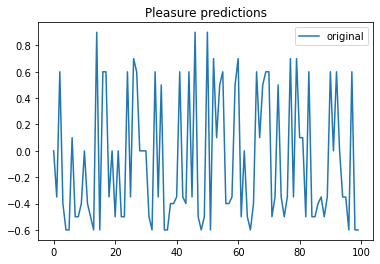

In [194]:
x_ax = range(100)
plt.plot(x_ax, test_y_p[0:100], label="original")

plt.title("Pleasure predictions")

plt.legend()
plt.show()

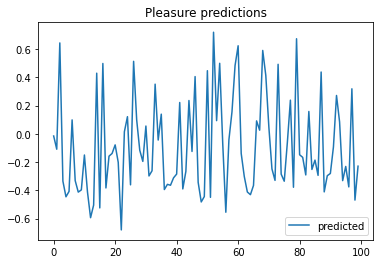

In [195]:
x_ax = range(100)
plt.plot(x_ax, pred_y_p[0:100], label="predicted")

plt.title("Pleasure predictions")

plt.legend()
plt.show()

In [ ]:
x_ax = range(len(test_y_a))
plt.plot(x_ax, test_y_a, label="original")
plt.plot(x_ax, pred_y_a, label="predicted")

plt.title("Arousal predictions")

plt.legend()
plt.show()

### Prediction Examples

In [ ]:
row=test_X.iloc[0]

x = np.asarray([row])

y_p = model_p.predict(x)
y_a = model_a.predict(x)

print('Real: %s' % np.asarray(test_y.iloc[0]))
print('Predicted: %s' % [y_p[0], y_a[0]])

In [ ]:
row=test_X.iloc[420]

x = np.asarray([row])

y_p = model_p.predict(x)
y_a = model_a.predict(x)

print('Real: %s' % np.asarray(test_y.iloc[420]))
print('Predicted: %s' % [y_p[0], y_a[0]])

In [ ]:
row=test_X.iloc[4000]

x = np.asarray([row])

y_p = model_p.predict(x)
y_a = model_a.predict(x)

print('Real: %s' % np.asarray(test_y.iloc[4000]))
print('Predicted: %s' % [y_p[0], y_a[0]])

## Save Models

In [56]:
# save to JSON
model_p.save_model("models/l2p_model.json")
model_a.save_model("models/l2a_model.json")

# save to text format
model_p.save_model("models/l2p_model.txt")
model_a.save_model("models/l2a_model.txt")

## Load Models

In [11]:
model_p = xgb.XGBRegressor(verbosity=0)
model_p.load_model("models/l2p_model_final.json")

model_a = xgb.XGBRegressor(verbosity=0)
model_a.load_model("models/l2a_model_final.json")

### Graphs

In [12]:
pred_y_p = model_p.predict(test_X)
mse = mean_squared_error(test_y_p, pred_y_p)
mae = mean_absolute_error(test_y_p, pred_y_p)
print("Pleasure")
print("MSE: %.2f" % mse)
print("MAE: %.2f" % mae)


pred_y_a = model_a.predict(test_X)
mse = mean_squared_error(test_y_a, pred_y_a)
mae = mean_absolute_error(test_y_a, pred_y_a)
print("\nArousal")
print("MSE: %.2f" % mse)
print("MAE: %.2f" % mae)

/home/ds/.local/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/home/ds/.local/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


Pleasure
MSE: 0.11
MAE: 0.23

Arousal
MSE: 0.08
MAE: 0.20


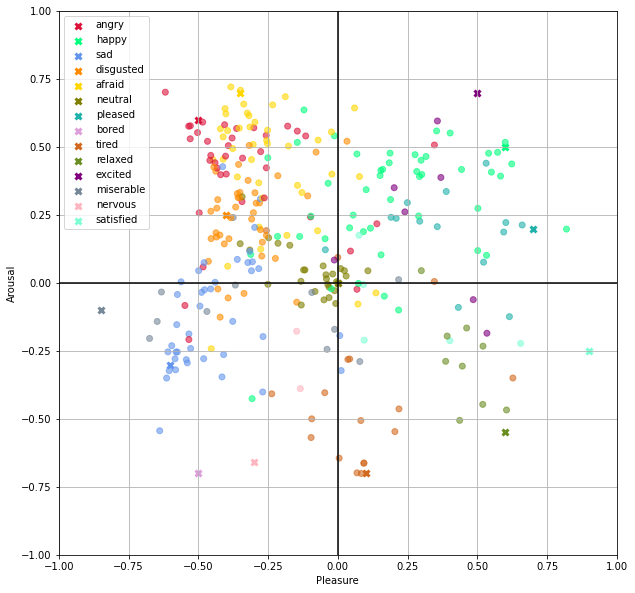

In [61]:
x = pred_y_p[0:300]
y = pred_y_a[0:300]

x_reference = [-0.5, 0.6, -0.6, -0.4, -0.35, 0.0, 0.7, -0.5, 0.1, 0.6, 0.5, -0.85, -0.3, 0.9]
y_reference = [0.6, 0.5, -0.3, 0.25, 0.7, 0.0, 0.2, -0.7, -0.7, -0.55, 0.7, -0.1, -0.66, -0.25]
colors_reference = ["crimson", "springgreen", "cornflowerblue", "darkorange", "gold", "olive", 
                    "lightseagreen", "plum", "chocolate", "olivedrab", "purple", "lightslategray",
                    "lightpink", "aquamarine"]

colors = []

color_map = {
    (-0.5, 0.6): "crimson",
    (0.6, 0.5): "springgreen",
    (-0.6, -0.3): "cornflowerblue",
    (-0.4, 0.25): "darkorange" ,
    (-0.35, 0.7): "gold",
    (0.0, 0.0): "olive", 
    (0.7, 0.2): "lightseagreen",
    (-0.5, -0.7): "plum",
    (0.1, -0.7): "chocolate",
    (0.6, -0.55): "olivedrab",
    (0.5, 0.7): "purple",
    (-0.85, -0.1): "lightslategray",
    (-0.3, -0.66): "lightpink",
    (0.9, -0.25): "aquamarine",
}

conv_dict = {
    (-0.5, 0.6): "angry",
    (0.6, 0.5): "happy",
    (-0.6, -0.3): "sad",
    (-0.4, 0.25): "disgusted" ,
    (-0.35, 0.7): "afraid",
    (0.0, 0.0): "neutral", 
    (0.7, 0.2): "pleased",
    (-0.5, -0.7): "bored",
    (0.1, -0.7): "tired",
    (0.6, -0.55): "relaxed",
    (0.5, 0.7): "excited",
    (-0.85, -0.1): "miserable",
    (-0.3, -0.66): "nervous",
    (0.9, -0.25): "satisfied",
    
}

for i in range(len(x)):
    point_coords = (test_y_p.iloc[i], test_y_a.iloc[i])
    
    colors.append(color_map[point_coords])

fig, ax = plt.subplots(figsize=(10,10))

for i in range(len(x_reference)):
    ax.scatter(x_reference[i], y_reference[i], c=colors_reference[i], label=conv_dict[(x_reference[i], y_reference[i])] , marker="x", linewidths=3)

ax.legend()

ax.scatter(x, y, c=colors, alpha=0.6)


line = mlines.Line2D([-1, 1], [0, 0], color='black')
line_2 = mlines.Line2D([0, 0], [-1, 1], color='black')
ax.add_line(line)
ax.add_line(line_2)


plt.ylim([-1,1])
plt.xlim([-1,1])


plt.xlabel('Pleasure')
plt.ylabel('Arousal')
plt.grid(True)

plt.show()



# Hyperparameter Grid Search with XGBoost

In [200]:
from datetime import datetime
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
import time

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import tensorflow as tf

import sklearn
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import mean_absolute_error


import xgboost as xgb

xgb.set_config(verbosity=0)

from sklearn.metrics import mean_squared_error

## Load Data

In [201]:
#dataset = pd.read_csv('datasets/pa/Fs_B_N_LMA_DATA.csv')
#dataset = pd.read_csv('datasets/pa/Fs_N_LMA_DATA.csv')
#dataset = pd.read_csv('datasets/pa/Fs_N_LMA_DATA_EXTRA.csv')
#dataset = pd.read_csv('datasets/pa/Fs2_N_LMA_DATA_EXTRA.csv')

dataset = pd.read_csv('datasets/pa/Fs_N_LMA_DATA_EXTRA_NEUTRAL.csv')

### Split into Test and Train data

In [202]:
train_dataset = dataset.sample(frac=0.8, random_state=42)
test_dataset = dataset.drop(train_dataset.index)

print("No Training Samples:",train_dataset.shape[0])
print("No Test Samples:",test_dataset.shape[0])

train_dataset = shuffle(train_dataset)
test_dataset = shuffle(test_dataset)

No Training Samples: 45087
No Test Samples: 11272


### Split Features from Targets

In [203]:
train_X = train_dataset.copy()
test_X = test_dataset.copy()

train_y = pd.concat([train_X.pop(x) for x in ['EMOTION_P', 'EMOTION_A']], axis=1)
test_y = pd.concat([test_X.pop(x) for x in ['EMOTION_P', 'EMOTION_A']], axis=1)

test_y_p = test_y.iloc[:,0]
train_y_p = train_y.iloc[:,0]

test_y_a = test_y.iloc[:,1]
train_y_a = train_y.iloc[:,1]

In [204]:
train_X.head()

avg_hand_distance  avg_l_hand_hip_distance  avg_r_hand_hip_distance  \
20060           0.326341                 0.278543                 0.215931   
51171           0.351379                 0.613145                 0.233814   
45              0.611422                 0.450835                 0.485425   
41236           0.248388                 0.203329                 0.187738   
46759           0.566658                 0.354489                 0.904407   

       avg_feet_distance  avg_l_hand_chest_distance  \
20060           0.126718                   0.628685   
51171           0.373425                   0.814615   
45              0.203940                   0.715695   
41236           0.093227                   0.588670   
46759           0.436247                   0.517851   

       avg_r_hand_chest_distance  avg_l_elbow_hip_distance  \
20060                   0.585598                  0.550684   
51171                   0.472974                  0.794014   
45                      0.443658                  0.654895   
41236                   0.570449                  0.503468   
46759                   0.949617                  0.385207   

       avg_r_elbow_hip_distance  avg_chest_pelvis_distance  \
20060                  0.508032                   0.262890   
51171                  0.337162                   0.264611   
45                     0.559491                   0.262996   
41236                  0.481326                   0.261633   
46759                  0.955074                   0.249014   

       avg_neck_chest_distance  ...  avg_pelvis_velocity_y  \
20060                 0.999881  ...               0.477107   
51171                 0.953509  ...               0.480842   
45                    0.999456  ...               0.476564   
41236                 0.998808  ...               0.477219   
46759                 0.984524  ...               0.479265   

       avg_pelvis_velocity_z  avg_l_foot_velocity_x  avg_l_foot_velocity_y  \
20060               0.481386               0.590563               0.618753   
51171               0.523682               0.594905               0.608959   
45                  0.482201               0.590955               0.629147   
41236               0.483041               0.590525               0.618454   
46759               0.579248               0.597859               0.613482   

       avg_l_foot_velocity_z  avg_r_foot_velocity_x  avg_r_foot_velocity_y  \
20060               0.335966               0.448620               0.496944   
51171               0.318693               0.447435               0.508526   
45                  0.335214               0.449009               0.503466   
41236               0.336130               0.448583               0.496756   
46759               0.314301               0.457932               0.511429   

       avg_r_foot_velocity_z  avg_upper_body_volume  avg_distance_traveled  
20060               0.538421               0.348004               0.002672  
51171               0.540617               0.364041               0.039767  
45                  0.537580               0.648522               0.006951  
41236               0.538606               0.291665               0.001550  
46759               0.499175               0.441044               0.076062  

[5 rows x 33 columns]

In [205]:
train_y.head()

EMOTION_P  EMOTION_A
20060       -0.6      -0.30
51171        0.6      -0.55
45           0.6       0.50
41236       -0.6      -0.30
46759        0.7       0.20

In [206]:
train_X.describe().transpose()[['mean', 'std']]

mean       std
avg_hand_distance          0.367866  0.202526
avg_l_hand_hip_distance    0.354570  0.185754
avg_r_hand_hip_distance    0.369125  0.193929
avg_feet_distance          0.221029  0.105025
avg_l_hand_chest_distance  0.566260  0.164762
avg_r_hand_chest_distance  0.563325  0.164601
avg_l_elbow_hip_distance   0.525713  0.154588
avg_r_elbow_hip_distance   0.526010  0.155729
avg_chest_pelvis_distance  0.268310  0.023227
avg_neck_chest_distance    0.982620  0.035712
avg_neck_rotation_w        0.476252  0.071978
avg_neck_rotation_x        0.438399  0.173934
avg_neck_rotation_y        0.443365  0.086577
avg_neck_rotation_z        0.921091  0.167569
avg_pelvis_rotation_w      0.518902  0.059338
avg_pelvis_rotation_x      0.437719  0.177642
avg_pelvis_rotation_y      0.421655  0.074516
avg_pelvis_rotation_z      0.925631  0.163795
std_l_hand_position        0.123915  0.127292
std_r_hand_position        0.126052  0.128747
avg_l_forearm_velocity     0.523746  0.065931
avg_r_forearm_velocity     0.466473  0.061265
avg_pelvis_velocity_x      0.595003  0.038377
avg_pelvis_velocity_y      0.476610  0.027967
avg_pelvis_velocity_z      0.481474  0.044548
avg_l_foot_velocity_x      0.590995  0.018215
avg_l_foot_velocity_y      0.619563  0.027526
avg_l_foot_velocity_z      0.335727  0.022738
avg_r_foot_velocity_x      0.448884  0.016939
avg_r_foot_velocity_y      0.497207  0.017822
avg_r_foot_velocity_z      0.538277  0.026444
avg_upper_body_volume      0.424719  0.175602
avg_distance_traveled      0.040045  0.045548

## Get Best

In [211]:
# A parameter grid for XGBoost
params = {
        'n_estimators': [500, 1000, 1500, 2000],
        'min_child_weight': [1, 5, 11, 22, 33],
        'gamma': [0, 0.1, 0.25, 0.5],
        'learning_rate': [0.05, 0.1, 0.15, 0.3, 0.5],
        'subsample': [1, 0.8, 0.5],
        'max_depth': [6, 10, 15, 20, 30],
        'lambda': [0.5, 1, 1.5, 2],
        'alpha': [0, 0.1, 0.5, 1]
        }

In [212]:
model_p = xgb.XGBRegressor(
                    n_estimators=2000, learning_rate=0.05, max_depth=10, min_child_weight=11, 
                    subsample=1, colsample_bytree=1, objective="reg:squarederror"
                )

model_a = xgb.XGBRegressor(
                    n_estimators=2000, learning_rate=0.05, max_depth=10, min_child_weight=11, 
                    subsample=1, colsample_bytree=1, objective="reg:squarederror"
                )

In [215]:
# Pleasure
# run randomized search
kfold = KFold(n_splits=10, shuffle=True)

n_iter_search = 100
random_search_p = RandomizedSearchCV(model_p, param_distributions=params,
                                   n_iter=n_iter_search, cv=kfold, scoring='neg_mean_absolute_error')

start = time.time()
random_search_p.fit(train_X, train_y_p)


print("RandomizedSearchCV took %.2f seconds for %d candidates"
      " parameter settings." % ((time.time() - start), n_iter_search))

/home/ds/.local/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/home/ds/.local/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/home/ds/.local/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/home/ds/.local/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a fu

/home/ds/.local/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/home/ds/.local/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/home/ds/.local/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/home/ds/.local/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a fu

/home/ds/.local/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/home/ds/.local/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/home/ds/.local/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/home/ds/.local/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a fu

KeyboardInterrupt: 

In [ ]:
# Arousal
# run randomized search
kfold = KFold(n_splits=10, shuffle=True)

n_iter_search = 100
random_search_a = RandomizedSearchCV(model_a, param_distributions=params,
                                   n_iter=n_iter_search, cv=kfold, scoring='neg_mean_absolute_error')

start = time.time()
random_search_a.fit(train_X, train_y_a)


print("RandomizedSearchCV took %.2f seconds for %d candidates"
      " parameter settings." % ((time.time() - start), n_iter_search))

## Results

In [60]:
best_regressor_p = random_search_p.best_estimator_

print(best_regressor_p.get_params())

{'objective': 'reg:linear', 'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bynode': 1, 'colsample_bytree': 1.0, 'enable_categorical': False, 'gamma': 0.5, 'gpu_id': -1, 'importance_type': None, 'interaction_constraints': '', 'learning_rate': 0.05, 'max_delta_step': 0, 'max_depth': 20, 'min_child_weight': 22, 'missing': nan, 'monotone_constraints': '()', 'n_estimators': 1000, 'n_jobs': 8, 'num_parallel_tree': 1, 'predictor': 'auto', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 1, 'scale_pos_weight': 1, 'subsample': 0.5, 'tree_method': 'exact', 'validate_parameters': 1, 'verbosity': None}


In [ ]:
best_regressor_a = random_search_a.best_estimator_

print(best_regressor_a.get_params())

In [ ]:
pred_y_p = best_regressor_p.predict(test_X)
mse = mean_squared_error(test_y_p, pred_y_p)
mae = mean_absolute_error(test_y_p, pred_y_p)
print("Pleasure")
print("MSE: %.2f" % mse)
print("MAE: %.2f" % mae)

pred_y_a = best_regressor_p.predict(test_X)
mse = mean_squared_error(test_y_a, pred_y_a)
mae = mean_absolute_error(test_y_a, pred_y_a)
print("\n\nArousal")
print("MSE: %.2f" % mse)
print("MAE: %.2f" % mae)

In [ ]:
x_ax = range(len(test_y_p))
plt.plot(x_ax, test_y_p, label="original")
plt.plot(x_ax, pred_y_p, label="predicted")

plt.title("Pleasure predictions")

plt.legend()
plt.show()

### Predictions

In [67]:
row=test_X.iloc[0]

x = np.asarray([row])

y_p = best_regressor_p.predict(x)
y_a = best_regressor_a.predict(x)

print('Real: %s' % np.asarray(test_y.iloc[0]))
print('Predicted: %s' % [y_p[0], y_a[0]])

Real: -0.5
Predicted: -0.23044229


# Neural Network for Regression (LMA features to P,A coordinates)

## Imports

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

from sklearn.model_selection import RepeatedKFold

2022-03-10 19:51:17.745214: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-03-10 19:51:17.745282: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


## Load Data

In [2]:
#dataset = pd.read_csv('datasets/pa/LMA_DATA.csv')
#dataset = pd.read_csv('datasets/pa/Fs_B_LMA_DATA.csv')

dataset = pd.read_csv('datasets/pa/Fs_LMA_DATA_EXTRA.csv')

### Split into Test and Train data

In [3]:
train_dataset = dataset.sample(frac=0.8, random_state=42)
test_dataset = dataset.drop(train_dataset.index)

print("No Training Samples:",train_dataset.shape[0])
print("No Test Samples:",test_dataset.shape[0])

No Training Samples: 45087
No Test Samples: 11272


### Split Features from Targets

In [4]:
train_X = train_dataset.copy()
test_X = test_dataset.copy()

train_y = pd.concat([train_X.pop(x) for x in ['EMOTION_P', 'EMOTION_A']], axis=1)
test_y = pd.concat([test_X.pop(x) for x in ['EMOTION_P', 'EMOTION_A']], axis=1)

In [5]:
train_X.head()

avg_hand_distance  avg_l_hand_hip_distance  avg_r_hand_hip_distance  \
5770            0.380282                 0.661481                 0.693188   
20189           0.760466                 0.506470                 0.499213   
55768           0.580429                 0.168741                 0.465727   
5563            0.473783                 0.286455                 0.248704   
53047           0.815654                 0.545759                 0.515166   

       avg_feet_distance  avg_l_hand_chest_distance  \
5770            0.369381                   0.480609   
20189           0.280216                   0.567541   
55768           0.278130                   0.418851   
5563            0.449423                   0.480491   
53047           0.417240                   0.429151   

       avg_r_hand_chest_distance  avg_l_elbow_hip_distance  \
5770                    0.458428                  0.432211   
20189                   0.307238                  0.443042   
55768                   0.543607                  0.287841   
5563                    0.461131                  0.361082   
53047                   0.430379                  0.412061   

       avg_r_elbow_hip_distance  avg_chest_pelvis_distance  \
5770                   0.406739                   0.286151   
20189                  0.275669                   0.286151   
55768                  0.427787                   0.286151   
5563                   0.343791                   0.286151   
53047                  0.387947                   0.286151   

       avg_neck_chest_distance  ...  avg_pelvis_velocity_y  \
5770                  0.278481  ...              -0.032571   
20189                 0.278833  ...               0.148304   
55768                 0.267957  ...               0.055718   
5563                  0.278724  ...               0.286956   
53047                 0.277062  ...              -0.268965   

       avg_pelvis_velocity_z  avg_l_foot_velocity_x  avg_l_foot_velocity_y  \
5770                0.463787               0.008890               0.521765   
20189              -0.986957               0.107026              -0.060120   
55768              -0.386061              -0.208628               1.608111   
5563                0.203860              -0.085325               0.126640   
53047               0.362865              -0.787257               1.232325   

       avg_l_foot_velocity_z  avg_r_foot_velocity_x  avg_r_foot_velocity_y  \
5770               -0.203105               0.008890               0.521765   
20189               0.487608               0.107026              -0.060120   
55768               1.892997              -0.512417              -0.950072   
5563                0.158180              -0.085325               0.126640   
53047               1.885969               0.323288               0.566038   

       avg_r_foot_velocity_z  avg_upper_body_volume  avg_distance_traveled  
5770               -0.203105               0.051152               0.004335  
20189               0.487608               0.043785               0.010320  
55768              -0.566143               0.027890               0.002431  
5563                0.158180               0.030401               0.002548  
53047              -2.243664               0.055453               0.003610  

[5 rows x 33 columns]

In [6]:
train_y.head()

EMOTION_P  EMOTION_A
5770       -0.35        0.7
20189      -0.35        0.7
55768      -0.85       -0.1
5563       -0.50        0.6
53047       0.50        0.7

In [7]:
train_X.describe().transpose()[['mean', 'std']]

mean           std
avg_hand_distance          0.529250  2.858826e-01
avg_l_hand_hip_distance    0.368487  1.767053e-01
avg_r_hand_hip_distance    0.384095  1.830527e-01
avg_feet_distance          0.338780  1.578916e-01
avg_l_hand_chest_distance  0.433375  1.218224e-01
avg_r_hand_chest_distance  0.435605  1.203586e-01
avg_l_elbow_hip_distance   0.342878  8.884460e-02
avg_r_elbow_hip_distance   0.348284  8.796934e-02
avg_chest_pelvis_distance  0.286151  7.207276e-10
avg_neck_chest_distance    0.277053  3.783007e-03
avg_neck_rotation_w       -0.006553  1.122287e-01
avg_neck_rotation_x       -0.044965  3.232766e-01
avg_neck_rotation_y       -0.073788  1.523782e-01
avg_neck_rotation_z        0.881896  2.507139e-01
avg_pelvis_rotation_w     -0.008579  8.910255e-02
avg_pelvis_rotation_x     -0.045808  3.302284e-01
avg_pelvis_rotation_y     -0.067394  1.271939e-01
avg_pelvis_rotation_z      0.888927  2.445222e-01
std_l_hand_position        0.946554  9.527397e-01
std_r_hand_position        0.976579  9.857990e-01
avg_l_forearm_velocity     0.028861  1.687643e+00
avg_r_forearm_velocity     0.032204  1.709835e+00
avg_pelvis_velocity_x      0.005840  3.695934e-01
avg_pelvis_velocity_y     -0.002192  2.586952e-01
avg_pelvis_velocity_z      0.002865  3.563536e-01
avg_l_foot_velocity_x      0.012743  9.709588e-01
avg_l_foot_velocity_y      0.000351  1.028966e+00
avg_l_foot_velocity_z     -0.007952  1.165969e+00
avg_r_foot_velocity_x      0.003867  9.121743e-01
avg_r_foot_velocity_y     -0.014228  1.061643e+00
avg_r_foot_velocity_z     -0.002313  1.210872e+00
avg_upper_body_volume      0.035811  1.284636e-02
avg_distance_traveled      0.003116  3.543725e-03

### Normalize Data

In [8]:
normalizer = tf.keras.layers.Normalization(axis=-1)
normalizer.adapt(np.array(train_X))

2022-03-10 19:51:57.070678: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-10 19:51:57.070951: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-03-10 19:51:57.071045: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory
2022-03-10 19:51:57.071113: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory
2022-03-10 19:51:57.071209: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Co

In [9]:
print(normalizer.mean.numpy())

[[ 5.2924943e-01  3.6848739e-01  3.8409463e-01  3.3877978e-01
   4.3337458e-01  4.3560424e-01  3.4287751e-01  3.4828344e-01
   2.8615117e-01  2.7705243e-01 -6.5531838e-03 -4.4965312e-02
  -7.3787861e-02  8.8189656e-01 -8.5787745e-03 -4.5807511e-02
  -6.7394182e-02  8.8892668e-01  9.4655275e-01  9.7657913e-01
   2.8861398e-02  3.2204371e-02  5.8395267e-03 -2.1922518e-03
   2.8645722e-03  1.2742929e-02  3.5076356e-04 -7.9521555e-03
   3.8666967e-03 -1.4228471e-02 -2.3128937e-03  3.5810597e-02
   3.1155969e-03]]


In [10]:
first = np.array(train_X[:1])

with np.printoptions(precision=2, suppress=True):
  print('First example:', first)
  print()
  print('Normalized:', normalizer(first).numpy())

First example: [[ 0.38  0.66  0.69  0.37  0.48  0.46  0.43  0.41  0.29  0.28  0.23 -0.27
  -0.03  0.94  0.17 -0.28 -0.03  0.94  0.67  0.86  0.34  0.17 -0.06 -0.03
   0.46  0.01  0.52 -0.2   0.01  0.52 -0.2   0.05  0.  ]]

Normalized: [[-0.52  1.66  1.69  0.19  0.39  0.19  1.01  0.66 -0.6   0.38  2.1  -0.68
   0.27  0.21  2.06 -0.71  0.31  0.22 -0.29 -0.12  0.18  0.08 -0.17 -0.12
   1.29 -0.    0.51 -0.17  0.01  0.5  -0.17  1.19  0.34]]


## Create Model

### Define Model Layers

In [11]:
# "Usually it's a good practice to apply following formula in order to find out the total number of hidden layers needed." - https://stackoverflow.com/questions/49008074/how-to-create-a-neural-network-for-regression

# Nh = Ns/(α∗ (Ni + No))
# where:
#      Ni = number of input neurons.
#      No = number of output neurons.
#      Ns = number of samples in training data set.
#      α = an arbitrary scaling factor usually 2-10.
 
# Nh = 34431 / (5 * (29 + 2)) +-= 230

def build_and_compile_model(norm):
    model = keras.Sequential([
                norm,
        
                layers.Dense(32, activation='relu'),
                layers.Dense(64, activation='relu'),
                layers.Dense(32, activation='relu'),
        
                layers.Dense(2)
            ])

    
    model.compile(loss='mean_absolute_error',optimizer='adam') # Using MAE
    #model.compile(loss='mean_squared_error', optimizer='adam') # Using MSE
    
    return model

### Build Model

In [12]:
model = build_and_compile_model(normalizer)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization (Normalizatio  (None, 33)               67        
 n)                                                              
                                                                 
 dense (Dense)               (None, 32)                1088      
                                                                 
 dense_1 (Dense)             (None, 64)                2112      
                                                                 
 dense_2 (Dense)             (None, 32)                2080      
                                                                 
 dense_3 (Dense)             (None, 2)                 66        
                                                                 
Total params: 5,413
Trainable params: 5,346
Non-trainable params: 67
_____________________________________________________

## Train Model

In [13]:
%%time
history = model.fit(
    train_X,
    train_y,
    validation_split=0.2,
    epochs=128, batch_size = 16, 
    verbose=2)

Epoch 1/128
2255/2255 - 3s - loss: 0.3520 - val_loss: 0.3318 - 3s/epoch - 1ms/step
Epoch 2/128
2255/2255 - 2s - loss: 0.3244 - val_loss: 0.3222 - 2s/epoch - 806us/step
Epoch 3/128
2255/2255 - 2s - loss: 0.3136 - val_loss: 0.3141 - 2s/epoch - 809us/step
Epoch 4/128
2255/2255 - 2s - loss: 0.3064 - val_loss: 0.3084 - 2s/epoch - 814us/step
Epoch 5/128
2255/2255 - 2s - loss: 0.3010 - val_loss: 0.3019 - 2s/epoch - 811us/step
Epoch 6/128
2255/2255 - 2s - loss: 0.2965 - val_loss: 0.3025 - 2s/epoch - 812us/step
Epoch 7/128
2255/2255 - 2s - loss: 0.2928 - val_loss: 0.2982 - 2s/epoch - 813us/step
Epoch 8/128
2255/2255 - 2s - loss: 0.2891 - val_loss: 0.2996 - 2s/epoch - 812us/step
Epoch 9/128
2255/2255 - 2s - loss: 0.2864 - val_loss: 0.2968 - 2s/epoch - 815us/step
Epoch 10/128
2255/2255 - 2s - loss: 0.2845 - val_loss: 0.2924 - 2s/epoch - 811us/step
Epoch 11/128
2255/2255 - 2s - loss: 0.2821 - val_loss: 0.2923 - 2s/epoch - 811us/step
Epoch 12/128
2255/2255 - 2s - loss: 0.2800 - val_loss: 0.2915 - 2

Epoch 97/128
2255/2255 - 2s - loss: 0.2418 - val_loss: 0.2769 - 2s/epoch - 807us/step
Epoch 98/128
2255/2255 - 2s - loss: 0.2411 - val_loss: 0.2790 - 2s/epoch - 821us/step
Epoch 99/128
2255/2255 - 2s - loss: 0.2409 - val_loss: 0.2763 - 2s/epoch - 806us/step
Epoch 100/128
2255/2255 - 2s - loss: 0.2406 - val_loss: 0.2798 - 2s/epoch - 816us/step
Epoch 101/128
2255/2255 - 2s - loss: 0.2405 - val_loss: 0.2755 - 2s/epoch - 814us/step
Epoch 102/128
2255/2255 - 2s - loss: 0.2406 - val_loss: 0.2765 - 2s/epoch - 828us/step
Epoch 103/128
2255/2255 - 2s - loss: 0.2405 - val_loss: 0.2745 - 2s/epoch - 850us/step
Epoch 104/128
2255/2255 - 2s - loss: 0.2404 - val_loss: 0.2781 - 2s/epoch - 813us/step
Epoch 105/128
2255/2255 - 2s - loss: 0.2405 - val_loss: 0.2759 - 2s/epoch - 822us/step
Epoch 106/128
2255/2255 - 2s - loss: 0.2405 - val_loss: 0.2763 - 2s/epoch - 808us/step
Epoch 107/128
2255/2255 - 2s - loss: 0.2397 - val_loss: 0.2766 - 2s/epoch - 811us/step
Epoch 108/128
2255/2255 - 2s - loss: 0.2396 - 

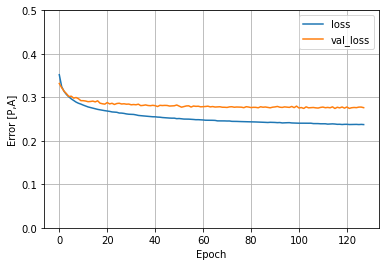

In [14]:
def plot_loss(history):
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.ylim([0, .5])
    plt.xlabel('Epoch')
    plt.ylabel('Error [P,A]')
    plt.legend()
    plt.grid(True)


plot_loss(history)

## Test Model

### Test

In [15]:
test_results = model.evaluate(test_X, test_y, verbose=2)
print("Mean Absolute Error:",test_results)

353/353 - 0s - loss: 0.2719 - 220ms/epoch - 624us/step
Mean Absolute Error: 0.27186521887779236


### Predictions

In [16]:
test_y.head()

EMOTION_P  EMOTION_A
2        -0.5        0.6
9        -0.5        0.6
10       -0.5        0.6
12       -0.5        0.6
16       -0.5        0.6

In [17]:
test_predictions = model.predict(test_X)

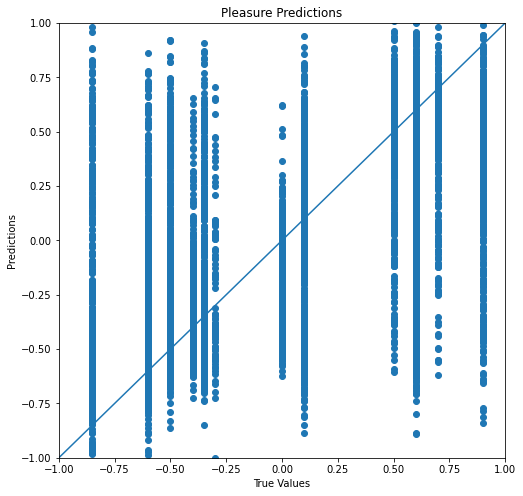

In [18]:
test_y_p = test_y.iloc[:,0]
pred_y_p = test_predictions[:,0]

fig = plt.figure(figsize=[8,8])

plt.scatter(test_y_p, pred_y_p)

plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.title('Pleasure Predictions')

lims = [-1,1]
plt.xlim(lims)
plt.ylim(lims)

plt.plot(lims, lims)

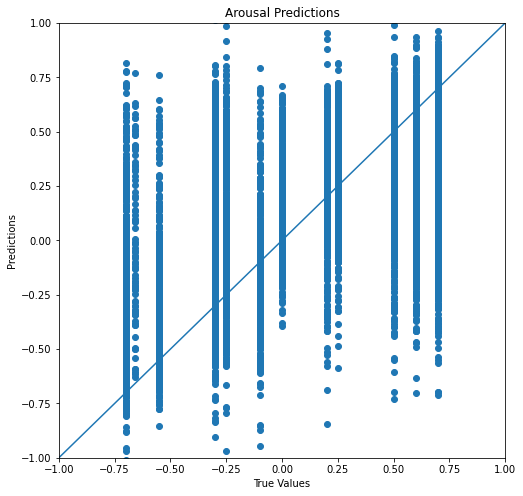

In [19]:
test_y_a = test_y.iloc[:,1]
pred_y_a = test_predictions[:,1]

fig = plt.figure(figsize=[8,8])

plt.scatter(test_y_a, pred_y_a)

plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.title('Arousal Predictions')

lims = [-1,1]
plt.xlim(lims)
plt.ylim(lims)

plt.plot(lims, lims)

### Prediction

In [20]:
row=test_X.iloc[3]

newX = np.asarray([row])
print(newX)

yhat = model.predict(newX)
print('Real: %s' % np.asarray(test_y.iloc[0]))
print('Predicted: %s' % yhat[0])

[[ 4.29294321e-01  3.06416764e-01  1.90160499e-01  4.80217455e-01
   4.81940802e-01  3.92710381e-01  3.68086612e-01  2.79621814e-01
   2.86151000e-01  2.78543929e-01  1.46260049e-03  7.27718893e-02
  -1.24973131e-01  9.88677098e-01 -7.23215648e-03  7.74506342e-02
  -7.46573787e-02  9.93415262e-01  3.44755140e-01  2.35700501e-01
   2.43901109e-01 -1.90304534e+00  1.11720574e-01  1.17148491e-02
  -2.64487607e-01 -3.25672018e-01 -1.32798951e+00 -1.13553977e-01
  -3.25672018e-01 -1.32798951e+00 -1.13553977e-01  2.75070287e-02
   2.29849149e-03]]
Real: [-0.5  0.6]
Predicted: [-0.52534443  0.1486804 ]


In [21]:
row=test_X.iloc[150]

newX = np.asarray([row])
print(newX)

yhat = model.predict(newX)
print('Real: %s' % np.asarray(test_y.iloc[0]))
print('Predicted: %s' % yhat[0])

[[ 1.17215946e-01  3.61241095e-01  3.99839017e-01  4.36527563e-01
   2.25056134e-01  2.50486207e-01  2.13999571e-01  2.25460328e-01
   2.86151000e-01  2.78802821e-01 -4.47469565e-02 -1.97556939e-02
  -1.22498981e-01  9.91259681e-01 -3.79469484e-02 -1.91014097e-02
  -9.71441635e-02  9.94360778e-01  1.50873400e+00  1.53570480e+00
   5.10256963e-03  2.48060947e-02 -6.57138458e-02  3.51885611e-03
   3.30361134e-02  1.60708801e-02 -3.23744358e-02  6.02535890e-02
   1.60708801e-02 -3.23744358e-02  6.02535890e-02  3.09335762e-02
   5.35708106e-04]]
Real: [-0.5  0.6]
Predicted: [-0.37035128  0.5560564 ]


In [22]:
row=test_X.iloc[69]

newX = np.asarray([row])
print(newX)

yhat = model.predict(newX)
print('Real: %s' % np.asarray(test_y.iloc[0]))
print('Predicted: %s' % yhat[0])

[[ 7.45094044e-01  3.08864935e-01  5.89613759e-01  2.16829686e-01
   4.88945356e-01  5.00097549e-01  3.68079471e-01  4.04840912e-01
   2.86151000e-01  2.78836833e-01 -4.74951927e-02  1.28751507e-02
  -1.02237442e-02  9.98701594e-01 -3.35488704e-02  1.02280769e-02
  -2.56976120e-02  9.99019439e-01  8.40703464e-01  8.31786194e-01
   7.28529193e-03 -1.12519885e+00 -4.73639152e-02  3.69714237e-03
  -3.61404533e-02 -3.79055102e-02  1.92132258e-01 -1.37202153e-01
  -3.79055102e-02  1.92132258e-01 -1.37202153e-01  3.92774494e-02
   3.67095874e-04]]
Real: [-0.5  0.6]
Predicted: [-0.0444088 -0.0207414]


# Gradient Boosting (LMA features to P,A coordinates)

## Imports

In [120]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import sklearn
import tensorflow as tf

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.ensemble import GradientBoostingRegressor

## Load Data

In [113]:
dataset = pd.read_csv('datasets/pa/Fs_B_N_LMA_DATA.csv')

### Split into Test and Train data

In [114]:
train_dataset = dataset.sample(frac=0.8, random_state=42)
test_dataset = dataset.drop(train_dataset.index)

print("No Training Samples:",train_dataset.shape[0])
print("No Test Samples:",test_dataset.shape[0])

No Training Samples: 8000
No Test Samples: 2000


### Split Features from Targets

In [115]:
train_X = train_dataset.copy()
test_X = test_dataset.copy()

train_y = pd.concat([train_X.pop(x) for x in ['EMOTION_P', 'EMOTION_A']], axis=1)
test_y = pd.concat([test_X.pop(x) for x in ['EMOTION_P', 'EMOTION_A']], axis=1)

test_y_p = test_y.iloc[:,0]
train_y_p = train_y.iloc[:,0]

test_y_a = test_y.iloc[:,1]
train_y_a = train_y.iloc[:,1]

In [116]:
train_X.head()

avg_hand_distance  avg_l_hand_hip_distance  avg_r_hand_hip_distance  \
6252           0.182161                 0.239957                 0.073864   
4684           0.445825                 0.270398                 0.307184   
1731           0.630929                 0.655890                 0.246729   
4742           0.713392                 0.546526                 0.452078   
4521           0.403415                 0.269620                 0.282995   

      avg_feet_distance  avg_l_hand_chest_distance  avg_r_hand_chest_distance  \
6252           0.239951                   0.627903                   0.481206   
4684           0.540458                   0.629404                   0.480568   
1731           0.060113                   0.653721                   0.612517   
4742           0.520810                   0.801025                   0.734590   
4521           0.051448                   0.644198                   0.634451   

      avg_l_elbow_hip_distance  avg_r_elbow_hip_distance  \
6252                  0.502666                  0.344620   
4684                  0.497964                  0.556971   
1731                  0.599840                  0.526427   
4742                  0.773689                  0.665912   
4521                  0.521853                  0.554992   

      avg_chest_pelvis_distance  avg_neck_chest_distance  ...  \
6252                   0.415943                 0.979307  ...   
4684                   0.355507                 0.977475  ...   
1731                   0.305967                 0.996776  ...   
4742                   0.339651                 0.989962  ...   
4521                   0.314383                 0.999728  ...   

      avg_pelvis_velocity_y  avg_pelvis_velocity_z  avg_l_foot_velocity_x  \
6252               0.581273               0.457494               0.579834   
4684               0.701403               0.453512               0.567967   
1731               0.574805               0.494450               0.583849   
4742               0.532673               0.334498               0.570885   
4521               0.584685               0.488869               0.583202   

      avg_l_foot_velocity_y  avg_l_foot_velocity_z  avg_r_foot_velocity_x  \
6252               0.408163               0.508905               0.625058   
4684               0.471092               0.594918               0.640870   
1731               0.422701               0.483744               0.630963   
4742               0.344419               0.486102               0.629931   
4521               0.422638               0.485936               0.630273   

      avg_r_foot_velocity_y  avg_r_foot_velocity_z  avg_upper_body_volume  \
6252               0.410921               0.481715               0.206246   
4684               0.502866               0.438463               0.529884   
1731               0.421293               0.454491               0.467607   
4742               0.353288               0.494141               0.682069   
4521               0.421230               0.457467               0.350990   

      avg_distance_traveled  
6252               0.093821  
4684               0.154873  
1731               0.005886  
4742               0.130044  
4521               0.006148  

[5 rows x 33 columns]

In [117]:
train_y.head()

EMOTION_P  EMOTION_A
6252        0.1       -0.7
4684        0.7        0.2
1731       -0.5        0.6
4742        0.7        0.2
4521        0.6        0.5

In [118]:
train_X.describe().transpose()[['mean', 'std']]

mean       std
avg_hand_distance          0.403083  0.223347
avg_l_hand_hip_distance    0.337277  0.200253
avg_r_hand_hip_distance    0.350649  0.198675
avg_feet_distance          0.246535  0.107873
avg_l_hand_chest_distance  0.603496  0.160886
avg_r_hand_chest_distance  0.589745  0.170321
avg_l_elbow_hip_distance   0.514783  0.171863
avg_r_elbow_hip_distance   0.543706  0.171387
avg_chest_pelvis_distance  0.323467  0.062589
avg_neck_chest_distance    0.973500  0.048300
avg_neck_rotation_w        0.419621  0.071443
avg_neck_rotation_x        0.439855  0.151033
avg_neck_rotation_y        0.422771  0.083809
avg_neck_rotation_z        0.942024  0.131383
avg_pelvis_rotation_w      0.474726  0.059747
avg_pelvis_rotation_x      0.432543  0.152147
avg_pelvis_rotation_y      0.467433  0.078508
avg_pelvis_rotation_z      0.945587  0.119850
std_l_hand_position        0.372793  0.176933
std_r_hand_position        0.370799  0.183757
avg_l_forearm_velocity     0.508280  0.069435
avg_r_forearm_velocity     0.431091  0.041335
avg_pelvis_velocity_x      0.548084  0.099633
avg_pelvis_velocity_y      0.574691  0.075237
avg_pelvis_velocity_z      0.494783  0.074325
avg_l_foot_velocity_x      0.583680  0.020146
avg_l_foot_velocity_y      0.422088  0.032834
avg_l_foot_velocity_z      0.486823  0.046077
avg_r_foot_velocity_x      0.629970  0.019218
avg_r_foot_velocity_y      0.421198  0.031831
avg_r_foot_velocity_z      0.457458  0.063123
avg_upper_body_volume      0.436529  0.210297
avg_distance_traveled      0.060930  0.070738

## Define Model

In [121]:
model_p = GradientBoostingRegressor()
model_a = GradientBoostingRegressor()

## Train Model

In [122]:
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)

### Pleasure Regression

In [123]:
n_scores = cross_val_score(model_p, train_X, train_y_p, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)
print('MAE: %.3f (%.3f)' % (np.mean(n_scores), np.std(n_scores)))

MAE: -0.236 (0.007)


In [124]:
model_p.fit(train_X, train_y_p)

GradientBoostingRegressor()

### Arousal Regression

In [125]:
n_scores = cross_val_score(model_a, train_X, train_y_a, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)
print('MAE: %.3f (%.3f)' % (np.mean(n_scores), np.std(n_scores)))

MAE: -0.240 (0.006)


In [126]:
model_a.fit(train_X, train_y_a)

GradientBoostingRegressor()

## Test Model

### Prediction

In [127]:
row=test_X.iloc[0]

x = np.asarray([row])

y_p = model_p.predict(x)
y_a = model_a.predict(x)

print('Real: %s' % np.asarray(test_y.iloc[0]))
print('Predicted: %s' % [y_p, y_a])

Real: [-0.35  0.7 ]
Predicted: [array([-0.16072887]), array([0.50489924])]


/home/ds/.local/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  warnings.warn(
/home/ds/.local/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  warnings.warn(


In [129]:
row=test_X.iloc[150]

x = np.asarray([row])

y_p = model_p.predict(x)
y_a = model_a.predict(x)

print('Real: %s' % np.asarray(test_y.iloc[0]))
print('Predicted: %s' % [y_p, y_a])

Real: [-0.35  0.7 ]
Predicted: [array([-0.25354781]), array([0.40621777])]


/home/ds/.local/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  warnings.warn(
/home/ds/.local/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  warnings.warn(


In [130]:
row=test_X.iloc[69]

x = np.asarray([row])

y_p = model_p.predict(x)
y_a = model_a.predict(x)

print('Real: %s' % np.asarray(test_y.iloc[0]))
print('Predicted: %s' % [y_p, y_a])

Real: [-0.35  0.7 ]
Predicted: [array([-0.27337685]), array([0.32014121])]


/home/ds/.local/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  warnings.warn(
/home/ds/.local/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  warnings.warn(
